<a id='intro'></a>
# Explore Dataset

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data preprocessing
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import IterativeStratification, iterative_train_test_split

# Modelling
import keras 
import keras.backend as K
from keras.callbacks import TensorBoard
from keras import optimizers
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

# Model Evaluation
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import hamming_loss, label_ranking_loss, average_precision_score 

# Plotting & Data visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pre-configure Plotting Style 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
%config InlineBackend.figure_format = 'retina'

# Miscellaneous
import os
import time
import random
import itertools 
from tqdm import tqdm
from collections import Counter

## Read Dataset

In [2]:
# Load data set
train = pd.read_csv('train.csv')

In [3]:
# Check dimensionality of dataset
train.shape

(7242, 27)

In [4]:
# Preview data
train.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# List Features
for i,v in enumerate(train):
    print(i, v)

0 Id
1 Genre
2 Action
3 Adventure
4 Animation
5 Biography
6 Comedy
7 Crime
8 Documentary
9 Drama
10 Family
11 Fantasy
12 History
13 Horror
14 Music
15 Musical
16 Mystery
17 N/A
18 News
19 Reality-TV
20 Romance
21 Sci-Fi
22 Short
23 Sport
24 Thriller
25 War
26 Western


In [6]:
print('Total number of genres: {}'.format(len(train.columns[2:])))
print('Total number of posters/images: {}'.format(train.Id.nunique()))
print('Total number of genre permutations: {}'.format(train.Genre.nunique()))

Total number of genres: 25
Total number of posters/images: 7231
Total number of genre permutations: 552


In [7]:
# Total counts per genre
train.sum()[2:].sort_values(ascending=False)

Drama          3619
Comedy         2900
Action         1343
Romance        1334
Crime          1176
Thriller        918
Adventure       870
Documentary     652
Horror          503
Fantasy         467
Mystery         454
Biography       441
Family          434
Sci-Fi          399
Music           305
Animation       244
History         224
Sport           221
War             144
Musical          97
Western          50
Short            45
News             21
N/A               0
Reality-TV        0
dtype: object

## Data Cleaning

In [8]:
# Drop N/A rows
na_rows = train[train.Genre.str.contains('N/A') == True].index
train = train.drop(na_rows, axis=0)

# Reality-TV rows
rt_rows = train[train.Genre.str.contains('Reality-TV') == True].index
train = train.drop(rt_rows, axis=0)

In [9]:
# Drop N/A, Reality-TV columns
train.drop(columns=['N/A','Reality-TV'], inplace=True)

# Reset index
train.reset_index(drop=True, inplace=True)

**Dropped the following 13 rows (also removed on original datset):**

- `N/A`
    - 3304    tt0116748
    - 3312    tt0289456
    - 3531    tt0282965
    - 3783    tt0322650
    - 4029    tt0402398
    - 4635    tt0468580
    - 4870    tt2546300
    - 5174    tt2546294
    - 5175    tt2546294
    - 7192    tt3521442
  
  
- `Reality-TV`
    - 4544    tt0808142
    - 6870    tt2884170

In [10]:
# Total counts per genre
train.sum()[2:].sort_values(ascending=False)

Drama          3619
Comedy         2900
Action         1343
Romance        1334
Crime          1176
Thriller        918
Adventure       870
Documentary     652
Horror          503
Fantasy         467
Mystery         454
Biography       441
Family          434
Sci-Fi          399
Music           305
Animation       244
History         224
Sport           221
War             144
Musical          97
Western          50
Short            45
News             21
dtype: object

### Convert Images to Array

In [11]:
# Read in images 
train_images = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('dataset/images/'+ train['Id'][i]+'.jpg', target_size=(250, 200, 3))
    img = image.img_to_array(img)
    img = img/255
    train_images.append(img)

100%|█████████████████████████████████████████████████████████████████████████████| 7242/7242 [00:31<00:00, 232.36it/s]


### Display Movie Posters

Genre of Movie Poster 1: ['Comedy', 'Drama', 'Romance'] 
Genre of Movie Poster 2: ['Action', 'Crime', 'Drama']


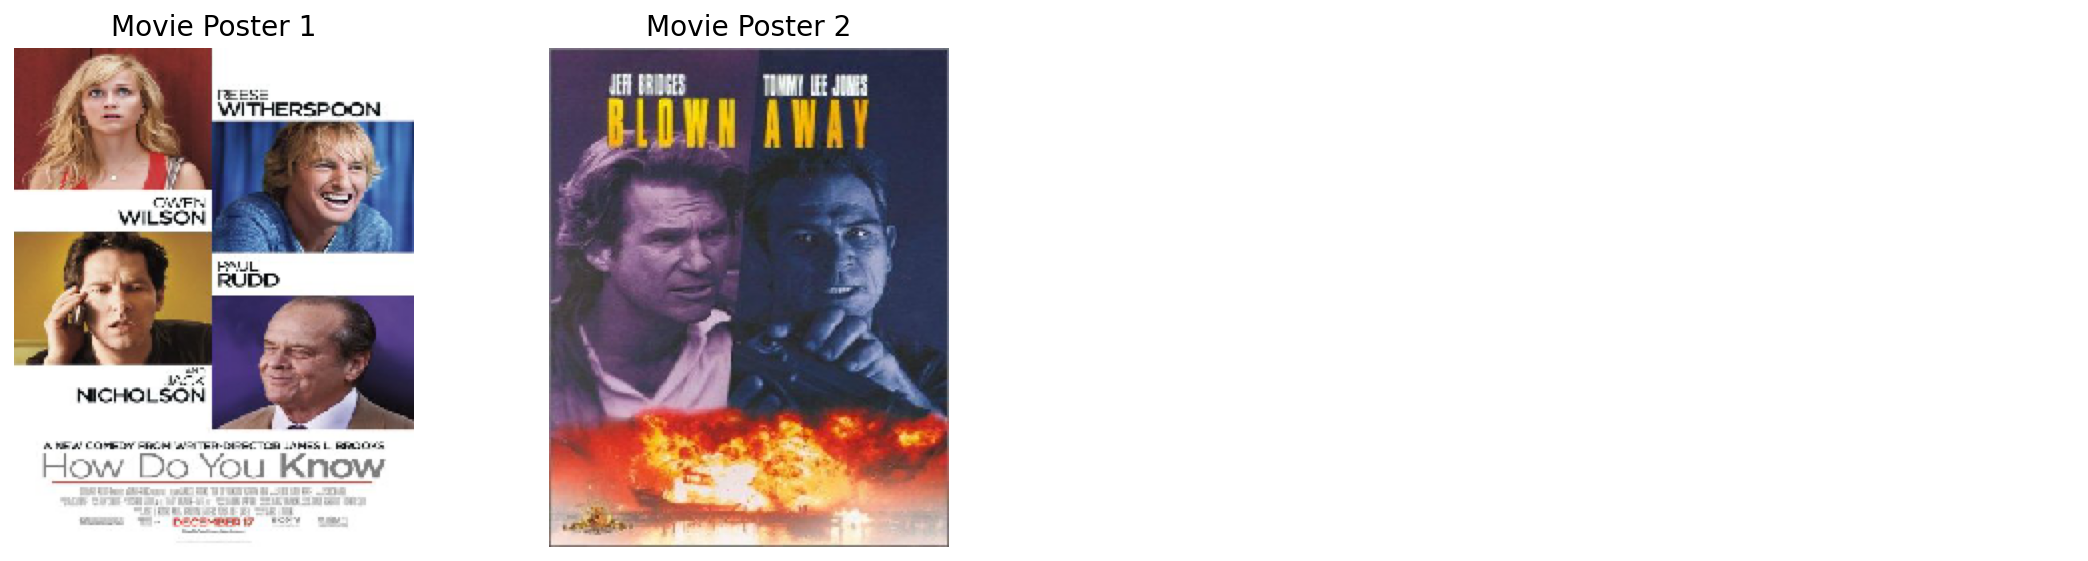

In [20]:
# Create a generator for random indexes
poster_index = list(range(7243))
rand_index = random.sample(poster_index, 2)

# Select random posters
poster_1, poster_2 = train_images[rand_index[0]], train_images[rand_index[1]]

# Display movie poster and title
fig, ax = plt.subplots(ncols = 4, figsize=(15, 4))
ax[0].imshow(poster_1)
ax[1].imshow(poster_2)
ax[0].set_title('Movie Poster 1', fontsize=14)
ax[1].set_title('Movie Poster 2', fontsize=14)

# Remove axes
for ax in ax:
    ax.axis('off')    
plt.tight_layout()

print('Genre of Movie Poster 1: {} \nGenre of Movie Poster 2: {}'.format(train['Genre'][rand_index[0]], train['Genre'][rand_index[1]]))

Sample of movie posters in the dataset

### Genre Counts

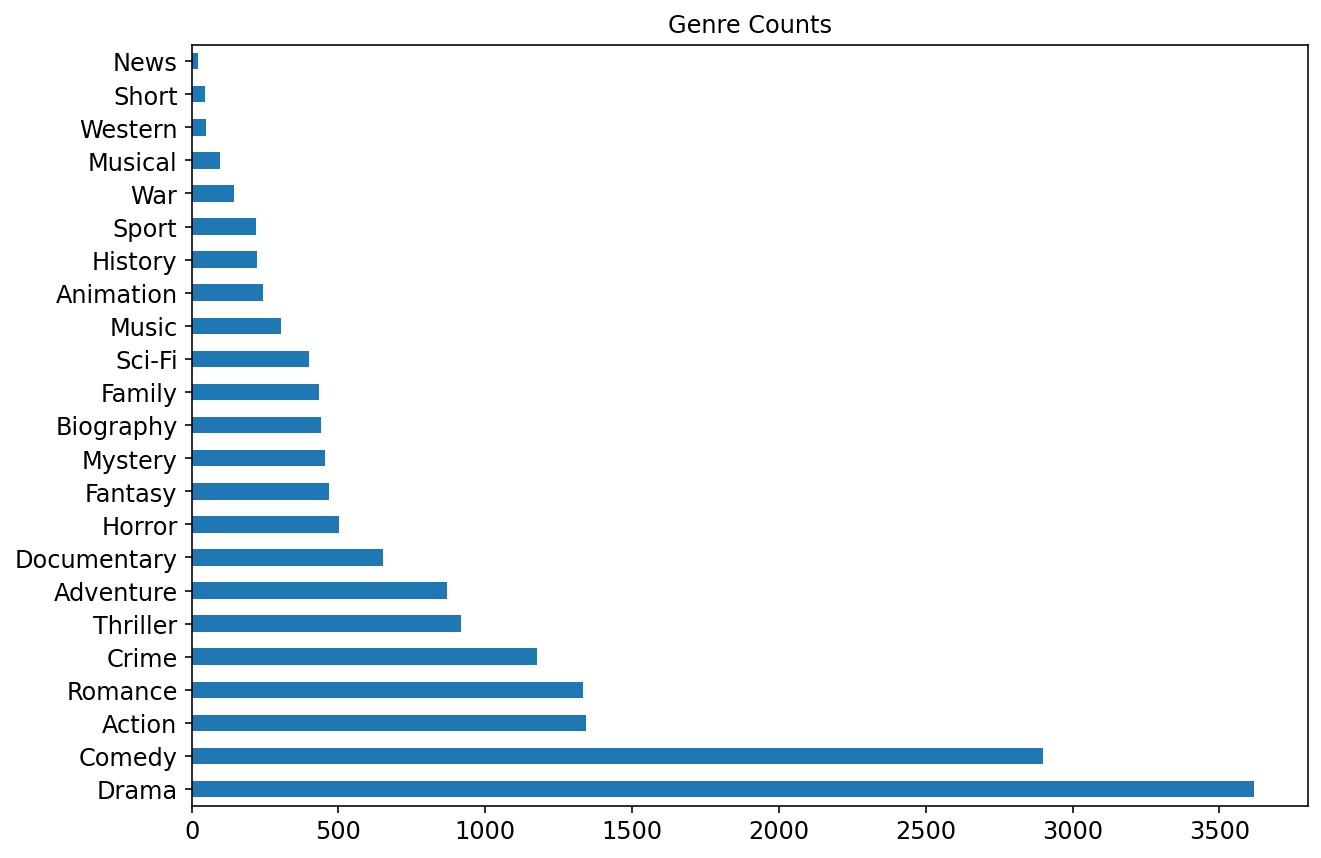

In [21]:
# Total counts per genre
train.sum()[2:].sort_values(ascending=False).plot(kind='barh', figsize=(10,7))
plt.title('Genre Counts');

### Mutli-label Counts

C:\Users\qwert\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


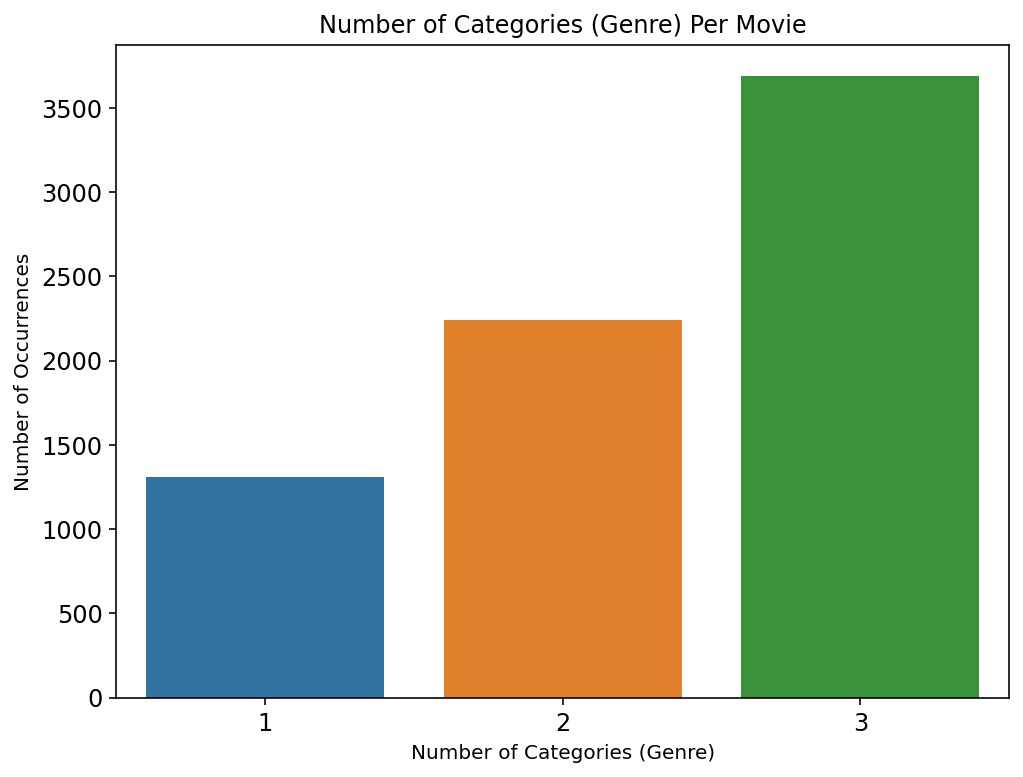

In [22]:
# Movies with multilabels
row_sum = train.iloc[:, 2:].sum(axis=1)
x = row_sum.value_counts()

# Plot barplot
plt.figure(figsize=(8,6))
ax = sns.barplot(x.index, x.values)
plt.title("Number of Categories (Genre) Per Movie", fontsize=12)
plt.ylabel('Number of Occurrences')
plt.xlabel('Number of Categories (Genre)');

### Unique Multi-label Classifications

In [23]:
# Identify permutation of Genres that appear only once
df_unique = train[train['Genre'].map(train['Genre'].value_counts()) < 2]

In [24]:
# Permutations of Genres that appear only once
len(df_unique.Genre.unique().tolist())

193

<a id='preprocessing'></a>
# Date Preprocessing

## Set up X and y

In [25]:
X = np.array(train_images)
y = np.array(train.drop(columns=['Id', 'Genre']))

## Train/Test Split (with Iterative Stratification)

In [26]:
# mskf = MultilabelStratifiedKFold(n_splits=2, random_state=42)

# for train_index, test_index in mskf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

## Train/Test Split

In [27]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size =0.2)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5793, 250, 200, 3), (1449, 250, 200, 3), (5793, 23), (1449, 23))

**Have to fix this:**
*The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2*

**To rectify this:**
Use ``from skmultilearn.model_selection import iterative_train_test_split`` for a more balanced split for multi-label problems or ``from iterstrat.ml_stratifiers import MultilabelStratifiedKFold`` for itertaive stratification

<a id='modelling'></a>
# Modelling

### Learning Curve Plot Function

In [29]:
# Function for plotting learning curves
def plot_curve(history, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['acc'])
    plt.plot(epoch_range, history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
  
    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    print('Mean Training Accuracy: ', round(np.mean(history.history['acc']), 3), '\nMean Testing Accuracy: ', round(np.mean(history.history['val_acc']), 3))
    print('Mean Training Loss: ', round(np.mean(history.history['loss']), 3), '\nMean Testing Loss: ', round(np.mean(history.history['val_loss']), 3))

## CNN Model

In [30]:
NAME = 'cnn-sig-bin-{}'.format(int(time.time()))
                               
tbCallback = TensorBoard(log_dir='logs/{}'.format(NAME))                        

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape =(250,200,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(23, activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 198, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 248, 198, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 99, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 124, 99, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 97, 32)       4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 122, 97, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 48, 32)        0

In [32]:
model.compile(loss='binary_crossentropy', metrics=['acc'])

In [33]:
history = model.fit(X_train, y_train, 
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    epochs=35,
                    callbacks=[tbCallback])

Epoch 1/35
182/182 [==============================] - 151s 676ms/step - loss: 0.8343 - acc: 0.0769 - val_loss: 0.8173 - val_acc: 0.1546
Epoch 2/35
182/182 [==============================] - 118s 648ms/step - loss: 0.3707 - acc: 0.2348 - val_loss: 0.3261 - val_acc: 0.1919
Epoch 3/35
182/182 [==============================] - 118s 648ms/step - loss: 0.2859 - acc: 0.2813 - val_loss: 0.2930 - val_acc: 0.1939
Epoch 4/35
182/182 [==============================] - 125s 688ms/step - loss: 0.2729 - acc: 0.2911 - val_loss: 0.2689 - val_acc: 0.2374
Epoch 5/35
182/182 [==============================] - 127s 697ms/step - loss: 0.2670 - acc: 0.3103 - val_loss: 0.2593 - val_acc: 0.2823
Epoch 6/35
182/182 [==============================] - 157s 863ms/step - loss: 0.2633 - acc: 0.3238 - val_loss: 0.2583 - val_acc: 0.2823
Epoch 7/35
182/182 [==============================] - 199s 1s/step - loss: 0.2569 - acc: 0.3352 - val_loss: 0.2612 - val_acc: 0.2636
Epoch 8/35
182/182 [==============================]

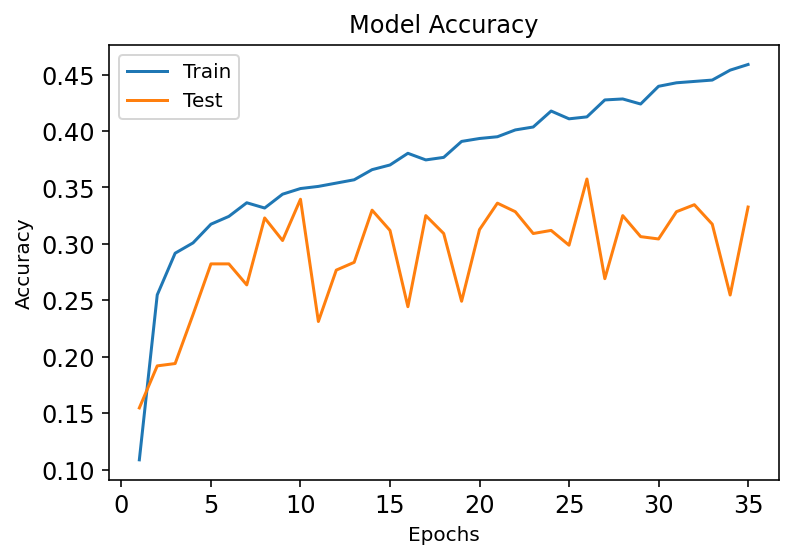

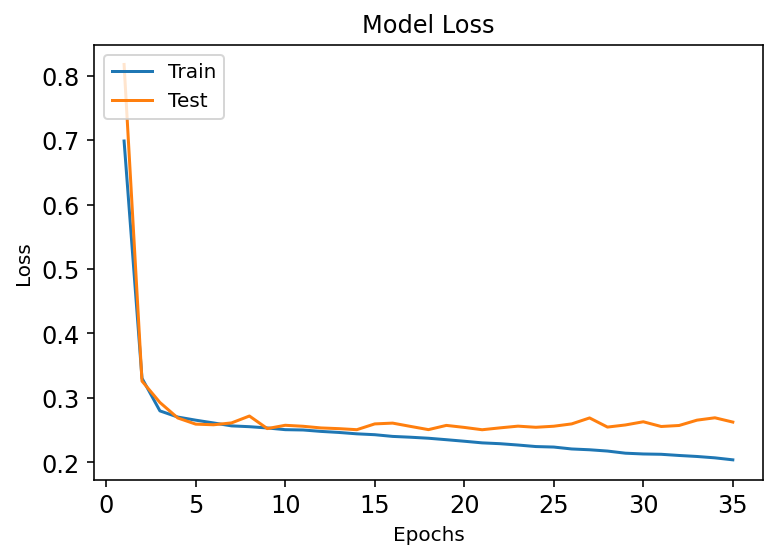

Mean Training Accuracy:  0.374 
Mean Testing Accuracy:  0.29
Mean Training Loss:  0.251 
Mean Testing Loss:  0.277


In [34]:
plot_curve(history, 35)

# Predictions on Test Images

In [35]:
def prediction(img_filepath, target_size=(250, 200, 3)):
    new_img = image.load_img(img_filepath, target_size=target_size)
    new_img = image.img_to_array(new_img) / 255
    
    classes = np.array(train.columns[2:])
    proba = model.predict(new_img.reshape(1,250,200,3))
    top_4 = np.argsort(proba[0])[:-5:-1]
    
    print('Genre Predictions:')
    for i in range(4):
        print('{}'.format(classes[top_4[i]])+' ({:.3})'.format(proba[0][top_4[i]]))
    plt.axis('off')
    plt.imshow(new_img)

Genre Predictions:
Comedy (0.632)
Drama (0.437)
Romance (0.196)
Family (0.194)


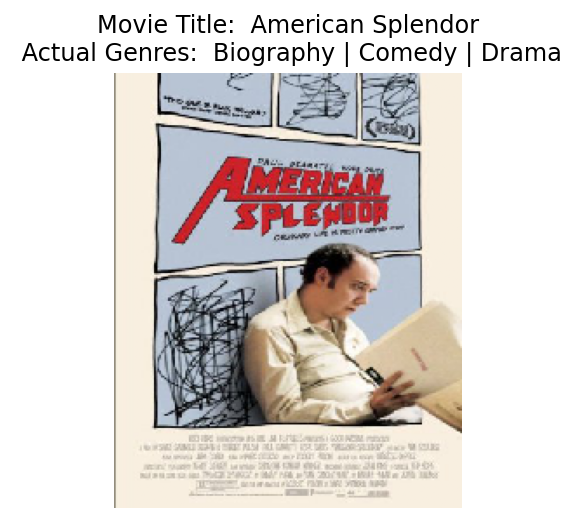

In [36]:
test_img = image.array_to_img(X_test[150])
plt.imshow(test_img)
plt.title('Movie Title:  American Splendor\n Actual Genres:  Biography | Comedy | Drama');
plt.axis('off')

prediction('dataset/images/tt0305206.jpg')

Genre Predictions:
Action (0.52)
Drama (0.465)
Thriller (0.235)
Crime (0.231)


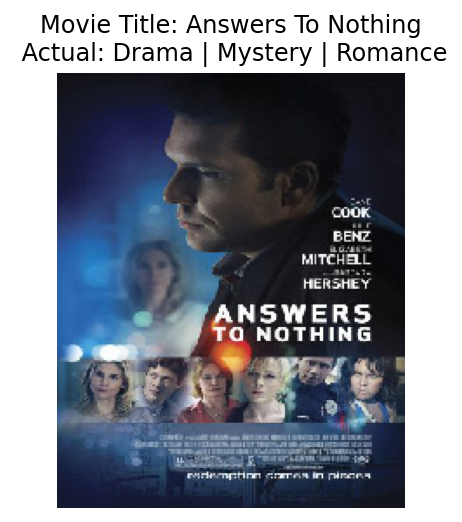

In [37]:
test_img_2 = image.array_to_img(X_test[555])
plt.imshow(test_img_2)
plt.axis('off')
plt.title('Movie Title: Answers To Nothing\n Actual: Drama | Mystery | Romance');
prediction('dataset/images/tt1523939.jpg')

Genre Predictions:
Action (0.422)
Comedy (0.368)
Drama (0.357)
Adventure (0.349)


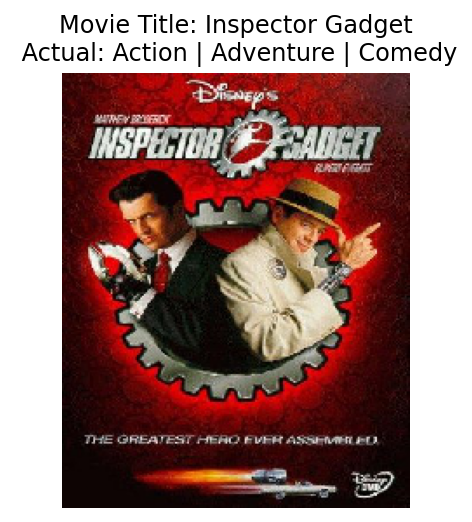

In [38]:
test_img_3 = image.array_to_img(X_test[800])
plt.imshow(test_img_3)
plt.axis('off')
plt.title('Movie Title: Inspector Gadget\n Actual: Action | Adventure | Comedy')
prediction('dataset/images/tt0141369.jpg')

Genre Predictions:
Horror (0.339)
Thriller (0.287)
Drama (0.211)
Sci-Fi (0.207)


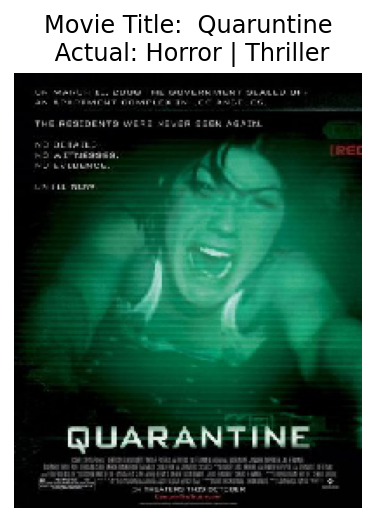

In [39]:
test_img_4 = image.array_to_img(X_test[1400])
plt.imshow(test_img_4)
plt.axis('off')
plt.title('Movie Title:  Quaruntine\n Actual: Horror | Thriller')
prediction('dataset/images/tt1082868.jpg')

# Predictions on Unseen Images

Genre Predictions:
Drama (0.72)
Comedy (0.422)
Romance (0.26)
Crime (0.0909)


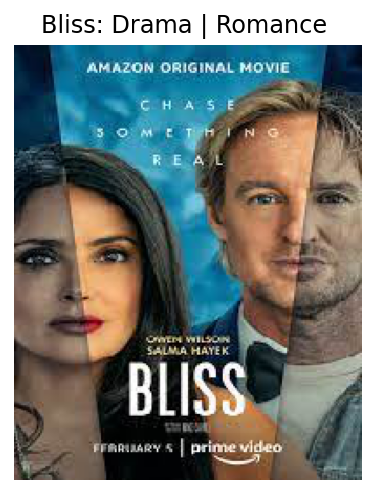

In [43]:
prediction('dataset/test_new/1.jpg')
plt.title('Bliss: Drama | Romance ');

Genre Predictions:
Comedy (0.967)
Family (0.303)
Adventure (0.268)
Animation (0.155)


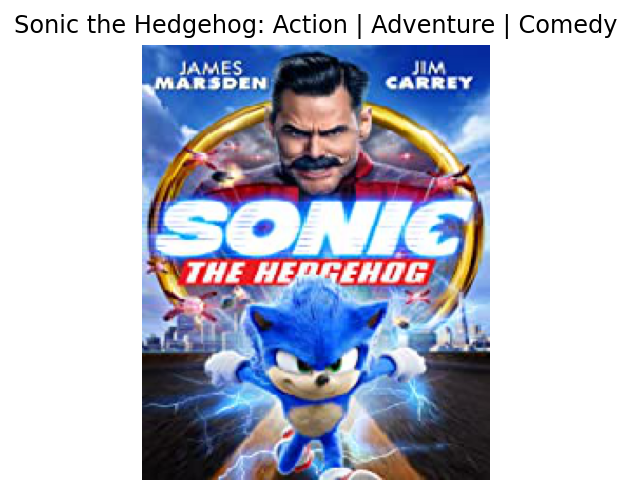

In [50]:
prediction('dataset/test_new/2.jpg')
plt.title('Sonic the Hedgehog: Action | Adventure | Comedy');

Genre Predictions:
Horror (0.411)
Drama (0.377)
Thriller (0.285)
Sci-Fi (0.26)


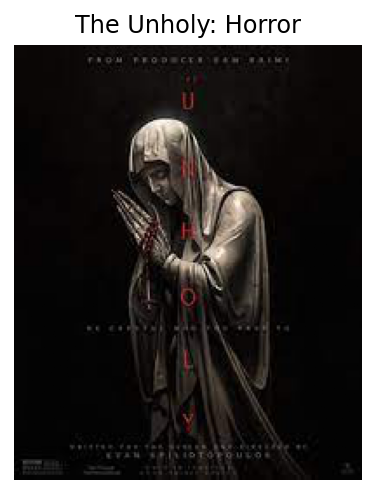

In [45]:
prediction('dataset/test_new/3.jpg')
plt.title('The Unholy: Horror');

Genre Predictions:
Adventure (0.546)
Comedy (0.401)
Action (0.363)
Family (0.264)


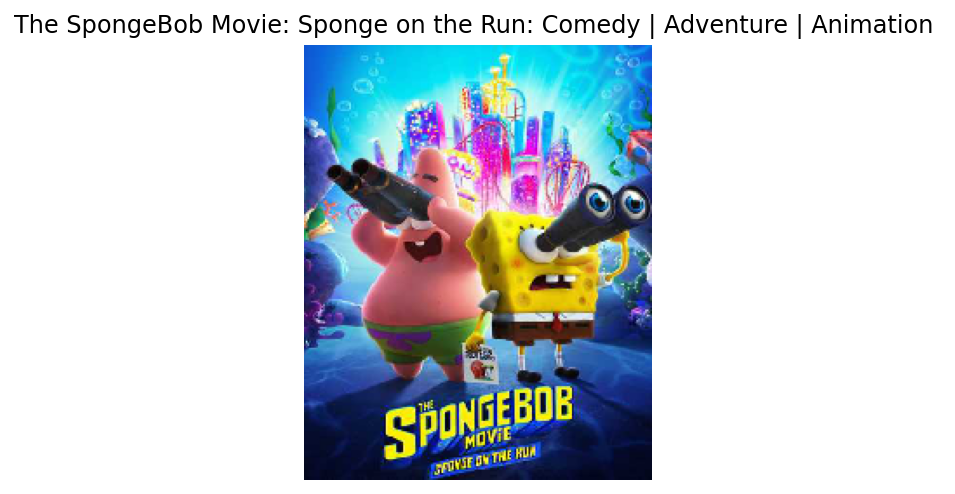

In [49]:
prediction('dataset/test_new/4.jpg')
plt.title('The SpongeBob Movie: Sponge on the Run: Comedy | Adventure | Animation ');

Genre Predictions:
Drama (0.832)
Romance (0.333)
Comedy (0.166)
Biography (0.145)


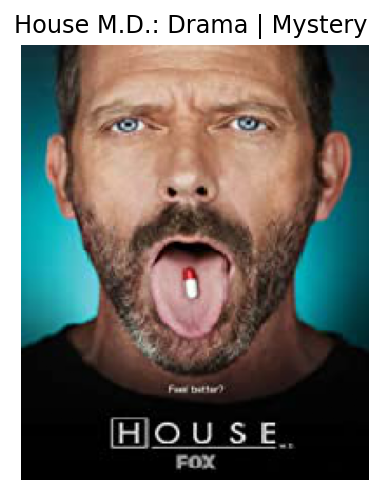

In [47]:
prediction('dataset/test_new/5.jpg')
plt.title('House M.D.: Drama | Mystery ');

## Multi-label Confusion Matrix

In [51]:
preds = model.predict(X_test)
preds = preds.argmax(axis=-1)

In [52]:
test_labels = y_test.argmax(axis=-1)

In [53]:
matrix = multilabel_confusion_matrix(test_labels, preds)
print(matrix)

[[[1104   75]
  [ 216   54]]

 [[1259   84]
  [  88   18]]

 [[1431    1]
  [  17    0]]

 [[1371    0]
  [  78    0]]

 [[ 842  152]
  [ 264  191]]

 [[1357    3]
  [  89    0]]

 [[1308   44]
  [  84   13]]

 [[ 614  557]
  [  76  202]]

 [[1447    0]
  [   2    0]]

 [[1440    0]
  [   9    0]]

 [[1448    0]
  [   1    0]]

 [[1385   32]
  [  28    4]]

 [[1448    0]
  [   1    0]]

 [[1447    0]
  [   2    0]]

 [[1447    0]
  [   2    0]]

 [[1448    0]
  [   1    0]]

 [[1439    8]
  [   2    0]]

 [[1432   11]
  [   6    0]]

 [[1448    0]
  [   1    0]]]


In [54]:
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.42      0.20      0.27       270
           1       0.18      0.17      0.17       106
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        78
           4       0.56      0.42      0.48       455
           5       0.00      0.00      0.00        89
           6       0.23      0.13      0.17        97
           7       0.27      0.73      0.39       278
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         1
          11       0.11      0.12      0.12        32
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         2
          20       0.00    

C:\Users\qwert\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hamming Loss


In [55]:
h_loss = hamming_loss(test_labels, preds)
print('Hamming Loss: {}'.format(round(h_loss, 3)))

Hamming Loss: 0.667


## Average Precision Score


In [56]:
y_pred_proba = model.predict(X_test)
ap_score = average_precision_score(y_test, y_pred_proba)
print('Avg. Precision Score: {}'.format(round(ap_score, 3)))

Avg. Precision Score: 0.195


## Ranking Loss


In [57]:
#y_pred_proba = model.predict(X_test)
ranking_loss = label_ranking_loss(y_test, y_pred_proba)
print('Ranking Loss: {}'.format(round(ranking_loss, 3)))

Ranking Loss: 0.168
